# Scraping, Cleaning and Optimization Codes

Function Used

In [ ]:
import requests
import bs4
import time
import sqlite3
import re
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import BaggingRegressor
        
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

%matplotlib inline
import matplotlib.pyplot as plt

# Obtain Unique Links of the Different Listings in Lamudi.PH

In [4]:
links = ['https://www.lamudi.com.ph/metro-manila/quezon-city/condominium/buy/?page=',
'https://www.lamudi.com.ph/metro-manila/makati/condominium/buy/?page=',
'https://www.lamudi.com.ph/metro-manila/taguig/condominium/buy/?page=',
'https://www.lamudi.com.ph/metro-manila/manila/condominium/buy/?page=',
'https://www.lamudi.com.ph/metro-manila/mandaluyong/condominium/buy/?page=',
'https://www.lamudi.com.ph/metro-manila/muntinlupa/condominium/buy/?page=',
'https://www.lamudi.com.ph/metro-manila/san-juan-5/condominium/buy/?page=',
'https://www.lamudi.com.ph/metro-manila/paranaque/condominium/buy/?page=',
'https://www.lamudi.com.ph/metro-manila/pasig/condominium/buy/?page=',
'https://www.lamudi.com.ph/metro-manila/las-pinas/condominium/buy/?page=']

In [3]:
list1 = []
for x in links:
    pages = np.arange(1,101)
    for nums in pages:
        try:
            link = x+str(nums)
            df = bs4.BeautifulSoup(requests.get(link,proxies=proxies).text)
            df1 = df.find_all(name='a',class_='js-listing-link')
            for x in df1:
                x1 = x['href']
                list1.append((x1))
        except:
            pass
list2 = set(list1)

# Create an SQL Database

In [5]:
conn = sqlite3.connect('lamudi_final.db')

conn.execute("""
    CREATE TABLE IF NOT EXISTS mytable (City TEXT NULL,Amount TEXT NULL,No_of_Bedroom TEXT NULL,No_of_Baths TEXT NULL,
        Floor_Area TEXT NULL,Amenities TEXT TEXT,Latitude TEXT NULL,L0ngitude TEXT NULL,GPath TEXT NULL,Index1 TEXT NULL,
        Title TEXT NULL,address TEXT NULL,link TEXT NULL,descrip TEXT NULL)""")

conn.commit()

# Program for Scraping

The Unique links of the different residential condominiums listings will be passed through the program below. The program will be getting the texts and string on the specified division tags that are needed for the data. The lamudi ph wbesite has rich information on its different division tags.

In [6]:
with tqdm(total=len(list2)) as pb:
    for x in list2:
        try:
            df2 = bs4.BeautifulSoup(requests.get(x).text)
            
            try:
                title= df2.find_all(class_="Header-title-block small-12 columns")[0].find_all('h1')[0].text
            except:
                title=None
                pass
            
            try:
                add=df2.find_all(class_="Header-title-block small-12 columns")[0].find_all('h3')[0].text.replace("   ","").replace('\n','').strip()

            except:
                add=None
                pass

            try:
                df3=df2.find_all(name='li',class_='icon-arrow-right')[2].text.replace('  ','').replace('\n','').replace('City:','')
            except:
                df3=None
                pass

            try:
                df4=df2.find_all(name='span',class_='Overview-main FirstPrice')[0].text.replace('₱ ','').replace(',','')
            except:
                df4=None
                pass

            try:
                df5=df2.find_all(name='section',id='listing-details')[0].text.replace("   ","").replace('\n','')
                try:
                    df6 = re.findall(r'Bedrooms   (.)',df5)[0]
                except:
                  
                    df6=None
                    pass
                try:
                    df7 = re.findall(r'Baths   (.)',df5)[0]
                except:
              
                    df7=None
                    pass
                try:
                    df8 = re.findall(r'Floor area \(m²\)   (.+?)[ |A-Z]',df5)[0]
                except:
                   
                    df8=None
                    pass
            except:
                df5=None
                pass
            
            try:
                df9 = df2.find_all(name='section',id='listing-amenities')[0].text
                df10 = df9.replace('\n','').replace('   ','').replace('  ',':').replace('Amenities ','').split(':')
            except:
                df10=None
                pass
            
            try:
                xylat = df2.find_all(name='div',class_='js-LeftLink-catalog')[0]['data-lat']
            except:
                xylat=None
                pass

            try:
                xylon = df2.find_all(name='div',class_='js-LeftLink-catalog')[0]['data-lon']
            except:
                xylon =None

                pass

            try:
                xypath = df2.find_all(name='div',class_='js-LeftLink-catalog')[0]['data-clp-path']
            except:
                xypath =None
                pass   
            
            try:
                descrip = df2.find(name='div',class_='ViewMore-text-description').text
            except:
                descrip = None
                pass   

            time.sleep(1)
            with conn:
                conn.execute("INSERT INTO mytable VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?,?)",
                             [df3,df4,df6,df7,df8,df9,xylat,xylon,xypath,df5,title,add,x,descrip])
        except:
            pass
        
        pb.update(1)
        

100%|██████████| 7001/7001 [4:40:14<00:00,  2.40s/it]  


In [3]:
conn = sqlite3.connect('lamudi_data.db')
table2 = pd.read_sql(""" SELECT * from mytable""",conn).drop('index',axis=1)

In [4]:
table2

,City,Amount,No_of_Bedroom,No_of_Baths,Floor_Area,Amenities,Latitude,L0ngitude,Index1
0,Makati,32500000,2,2,158,\nAmenities\n\n\n\n\n CCTV\n ...,14.56036,121.02202,DetailsCar Spaces 2Bedrooms 2Baths 2Floo...
1,Quezon City,2800000,1,None,None,\nAmenities\n\n\n\n\n CCTV\n ...,14.620208,120.99982,DetailsBedrooms 1Available from 18/08/2020
2,Manila,8500000,2,2,52,\nAmenities\n\n\n\n\n Gymnasium\n ...,14.5581118,120.9937707,DetailsBedrooms 2Baths 2Floor area (m²) ...
3,San Juan,31000000,3,3,155.81,\nAmenities\n\n\n\n\n Gymnasium\n ...,14.600676,121.43876,DetailsCar Spaces 2Bedrooms 3Baths 3Floo...
4,Makati,113900000,3,None,304,\nAmenities\n\n\n\n\n CCTV\n ...,14.555756,121.029209,DetailsCar Spaces 3Bedrooms 3Floor area (m...
...,...,...,...,...,...,...,...,...,...
14816,Quezon City,1800000,1,1,18.67,\nAmenities\n\n\n\n\n Alarm System\n ...,14.66134,121.03317,DetailsCar Spaces 14Bedrooms 1Baths 1Flo...
14817,Makati,18000000,1,1,65,\nAmenities\n\n\n\n\n Alarm System\n ...,14.5506662,121.0215775,DetailsBedrooms 1Baths 1Floor area (m²) ...
14818,Quezon City,5400000,2,2,92.512,\nAmenities\n\n\n\n\n Air conditioning\n ...,14.6621443,121.0443089,DetailsBedrooms 2Baths 2Floor area (m²) ...
14819,Quezon City,3124000,1,1,27.9,\nAmenities\n\n\n\n\n CCTV\n ...,14.6159491,121.054178,DetailsBuild (Year) 2018Deposit / Bond 200...


# Cleaning Process

In [5]:
table2['Amount']= pd.to_numeric(table2['Amount'], errors='coerce')
table2['No_of_Bedroom']= pd.to_numeric(table2['No_of_Bedroom'], errors='coerce')
table2['No_of_Baths']= pd.to_numeric(table2['No_of_Baths'], errors='coerce')
table2['Floor_Area']= pd.to_numeric(table2['Floor_Area'], errors='coerce')
table2['Latitude']= pd.to_numeric(table2['Latitude'], errors='coerce')
table2['L0ngitude']= pd.to_numeric(table2['L0ngitude'], errors='coerce')
table2=table2.drop((table2[table2['Amount']> 30_000_000]).index)
table2['newAm'] = table2['Amenities']
table2['countnewAm'] = table2['Amenities']
for x1,x2 in table2['Amenities'].items():
    x3 = x2.replace('\n','').replace('   ','').replace('  ',':').replace('Amenities ','').strip().split(':')
    table2['newAm'].loc[x1]=x3
    try:
        table2['countnewAm'].loc[x1]=len(np.unique(x3))
    except:
        table2['countnewAm'].loc[x1]=0
        pass
    
table2=table2.drop(['Amenities','newAm'],axis=1)
table2=table2.drop(table2[table2.duplicated()].index)
table2['floor_number']=table2['Index1'].str.extract(r'Unit/Floor Number   ([0-9]{2}|[0-9])')
table2['floor_number']= pd.to_numeric(table2['floor_number'], errors='coerce')
table2=table2.drop('Index1',axis=1)
table2=table2.drop(table2[table2.duplicated()].index)
table2=table2.drop((table2[table2['Floor_Area']> 200]).index)
table2=table2.drop((table2[table2['Floor_Area']< 10]).index)
table2=table2.drop((table2[table2['floor_number']> 70]).index)
table2=table2.drop((table2[table2['Latitude']>15]).index)
table2=table2.drop((table2[table2['Amount']< 2000000]).index)
table2=table2.drop(table2[table2.duplicated()].index)
table2=table2.drop(9944)
table2=table2.dropna()


C:\Users\Ralph Caubalejo\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
table2

,City,Amount,No_of_Bedroom,No_of_Baths,Floor_Area,Latitude,L0ngitude,countnewAm,floor_number
2,Manila,8500000.0,2.0,2.0,52.000,14.558112,120.993771,17,10.0
6,San Juan,15700000.0,2.0,1.0,132.390,14.603980,121.045000,4,2.0
7,Quezon City,3300000.0,1.0,1.0,23.000,14.651189,121.032754,24,18.0
9,Mandaluyong,4500000.0,1.0,1.0,30.260,14.572573,121.048343,33,15.0
10,Pasig,20645110.0,3.0,3.0,129.000,14.582640,121.078700,93,28.0
...,...,...,...,...,...,...,...,...,...
14810,Las Piñas,6500000.0,2.0,1.0,58.000,14.468350,120.969780,36,5.0
14813,Mandaluyong,2300000.0,1.0,1.0,20.010,14.574420,121.050700,20,15.0
14815,Makati,10300000.0,1.0,1.0,29.000,14.566278,121.037021,34,10.0
14818,Quezon City,5400000.0,2.0,2.0,92.512,14.662144,121.044309,6,30.0


In [7]:
table2['City'] = table2['City'].astype('category')
citylist = list(zip(table2['City'].cat.codes, table2['City']))
table2['City'] = table2['City'].cat.codes

In [8]:
set(citylist)

{(0, 'Antipolo'),
 (1, 'Las Piñas'),
 (2, 'Makati'),
 (3, 'Mandaluyong'),
 (4, 'Manila'),
 (5, 'Muntinlupa'),
 (6, 'Parañaque'),
 (7, 'Pasay'),
 (8, 'Pasig'),
 (9, 'Quezon City'),
 (10, 'San Juan'),
 (11, 'Taguig')}

In [9]:
table2

,City,Amount,No_of_Bedroom,No_of_Baths,Floor_Area,Latitude,L0ngitude,countnewAm,floor_number
2,4,8500000.0,2.0,2.0,52.000,14.558112,120.993771,17,10.0
6,10,15700000.0,2.0,1.0,132.390,14.603980,121.045000,4,2.0
7,9,3300000.0,1.0,1.0,23.000,14.651189,121.032754,24,18.0
9,3,4500000.0,1.0,1.0,30.260,14.572573,121.048343,33,15.0
10,8,20645110.0,3.0,3.0,129.000,14.582640,121.078700,93,28.0
...,...,...,...,...,...,...,...,...,...
14810,1,6500000.0,2.0,1.0,58.000,14.468350,120.969780,36,5.0
14813,3,2300000.0,1.0,1.0,20.010,14.574420,121.050700,20,15.0
14815,2,10300000.0,1.0,1.0,29.000,14.566278,121.037021,34,10.0
14818,9,5400000.0,2.0,2.0,92.512,14.662144,121.044309,6,30.0


In [50]:
table2.to_csv('lamudi_clean.csv', index=False)

In [11]:
table2 = pd.read_csv('lamudi_clean.csv')

In [12]:
table2

,City,Amount,No_of_Bedroom,No_of_Baths,Floor_Area,Latitude,L0ngitude,countnewAm,floor_number
0,4,8500000.0,2.0,2.0,52.000,14.558112,120.993771,17,10.0
1,10,15700000.0,2.0,1.0,132.390,14.603980,121.045000,4,2.0
2,9,3300000.0,1.0,1.0,23.000,14.651189,121.032754,24,18.0
3,3,4500000.0,1.0,1.0,30.260,14.572573,121.048343,33,15.0
4,8,20645110.0,3.0,3.0,129.000,14.582640,121.078700,93,28.0
...,...,...,...,...,...,...,...,...,...
6516,1,6500000.0,2.0,1.0,58.000,14.468350,120.969780,36,5.0
6517,3,2300000.0,1.0,1.0,20.010,14.574420,121.050700,20,15.0
6518,2,10300000.0,1.0,1.0,29.000,14.566278,121.037020,34,10.0
6519,9,5400000.0,2.0,2.0,92.512,14.662144,121.044309,6,30.0


# Optimization and Tuning the Parameters

In [13]:
table = pd.DataFrame(columns = ['Train_Accuracy','Test_Accuracy', 'Optimal Parameter'])

# KNN Optimization

Iter: 5:  80%|████████  | 76/95 [00:03<00:00, 19.25it/s]


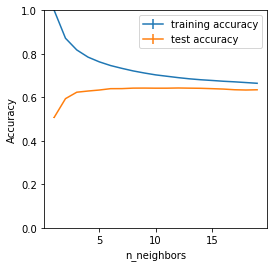

Highest Test Set Achieved = 0.643385
Best Nearest Neighbor Parameter = 12


In [14]:
X = table2.drop('Amount',axis=1)
y = table2['Amount']
yz=5
neighbors_settings = range(1, 20)
lahat_train = pd.DataFrame()
lahat_test = pd.DataFrame()

with tqdm(total=yz*len(neighbors_settings)) as pb:
    for seedN in range(1,yz,1):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                            test_size=0.25, random_state=seedN)

        training_accuracy = []
        test_accuracy = []

        pb.set_description(f'Iter: {seedN+1}')
        for n_neighbors in neighbors_settings:   
            clf = KNeighborsRegressor(n_neighbors=n_neighbors)  # build the model
            clf.fit(X_train, y_train)

            training_accuracy.append(clf.score(X_train, y_train)) # record training set accuracy
            test_accuracy.append(clf.score(X_test, y_test))   # record generalization accuracy
            
            pb.update(1)
            
        lahat_train[seedN]= training_accuracy
        lahat_test[seedN] = test_accuracy

fig = plt.figure(figsize=(4,4))
plt.errorbar(neighbors_settings, lahat_train.mean(axis=1),
             yerr=lahat_train.var(axis=1), label="training accuracy")
plt.errorbar(neighbors_settings, lahat_test.mean(axis=1),
             yerr=lahat_test.var(axis=1), label="test accuracy")

plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.ylim(0,1)
plt.legend()
plt.show()

n_neighbor_best= np.argmax(lahat_test.mean(axis=1)) +1
print("Highest Test Set Achieved = %f" % np.amax(lahat_test.mean(axis=1)))
print("Best Nearest Neighbor Parameter = %d" %n_neighbor_best)
table.loc['KNN'] = [np.amax(lahat_train.mean(axis=1)),np.amax(lahat_test.mean(axis=1)), n_neighbor_best]

# Linear Regression Optimization

Iter: 5: 100%|██████████| 5/5 [00:00<00:00, 113.94it/s]


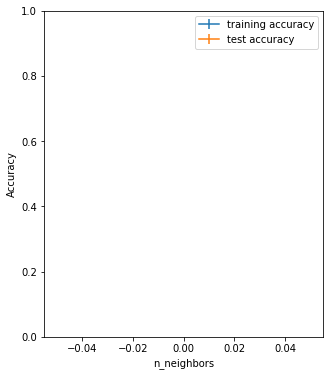

Highest Test Set Achieved = 0.625265


In [15]:
X = table2.drop('Amount',axis=1)
y = table2['Amount']
yz=5
neighbors_settings = range(0, 1)
lahat_train = pd.DataFrame()
lahat_test = pd.DataFrame()

with tqdm(total=yz*len(neighbors_settings)) as pb:
    for seedN in range(0,yz):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                            test_size=0.25, random_state=seedN)

        training_accuracy = []
        test_accuracy = []

        pb.set_description(f'Iter: {seedN+1}')
        for n_neighbors in neighbors_settings:   
            clf = LinearRegression()  # build the model
            clf.fit(X_train, y_train)

            training_accuracy.append(clf.score(X_train, y_train)) # record training set accuracy
            test_accuracy.append(clf.score(X_test, y_test))   # record generalization accuracy
            
            pb.update(1)
            
        lahat_train[seedN]= training_accuracy
        lahat_test[seedN] = test_accuracy

fig = plt.figure(figsize=(5, 6))
plt.errorbar(neighbors_settings, lahat_train.mean(axis=1),
             yerr=lahat_train.var(axis=1), label="training accuracy")
plt.errorbar(neighbors_settings, lahat_test.mean(axis=1),
             yerr=lahat_test.var(axis=1), label="test accuracy")

plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.ylim(0,1)
plt.legend()
plt.show()

print("Highest Test Set Achieved = %f" % np.amax(lahat_test.mean(axis=1)))

table.loc['LR'] = [np.amax(lahat_train.mean(axis=1)),np.amax(lahat_test.mean(axis=1)), 'N/A']


# Ridge Regression Optimization

Iter: 5: 100%|██████████| 95/95 [00:00<00:00, 303.31it/s]


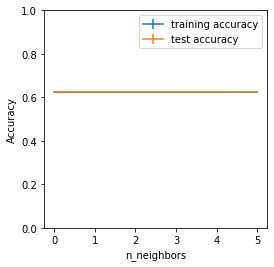

Highest Test Set Achieved = 0.625265
Best Alpha = 1e-12


In [16]:
X = table2.drop('Amount',axis=1)
y = table2['Amount']
yz=5
neighbors_settings=[1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,
                            1e-3,1e-2,0.1, 0.2,0.4,0.75, 1, 1.5, 3, 5]
lahat_train = pd.DataFrame()
lahat_test = pd.DataFrame()

with tqdm(total=yz*len(neighbors_settings)) as pb:
    for seedN in range(0,yz):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                            test_size=0.25, random_state=seedN)

        training_accuracy = []
        test_accuracy = []

        pb.set_description(f'Iter: {seedN+1}')
        
        neighbors_settings=[1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,
                            1e-3,1e-2,0.1, 0.2,0.4,0.75, 1, 1.5, 3, 5]
        
        for n_neighbors in neighbors_settings:   
            clf = Ridge(alpha=n_neighbors)  # build the model
            clf.fit(X_train, y_train)

            training_accuracy.append(clf.score(X_train, y_train)) # record training set accuracy
            test_accuracy.append(clf.score(X_test, y_test))   # record generalization accuracy
            
            pb.update(1)
            
        lahat_train[seedN]= training_accuracy
        lahat_test[seedN] = test_accuracy
        
fig = plt.figure(figsize=(4,4))
plt.errorbar(neighbors_settings, lahat_train.mean(axis=1),
             yerr=lahat_train.var(axis=1), label="training accuracy")
plt.errorbar(neighbors_settings, lahat_test.mean(axis=1),
             yerr=lahat_test.var(axis=1), label="test accuracy")

plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.ylim(0,1)
plt.legend()
plt.show()

n_neighbor_best= np.argmax(lahat_test.mean(axis=1))
print("Highest Test Set Achieved = %f" % np.amax(lahat_test.mean(axis=1)))
print("Best Alpha =",neighbors_settings[n_neighbor_best])
table.loc['Ridge'] = [np.amax(lahat_train.mean(axis=1)),np.amax(lahat_test.mean(axis=1)), neighbors_settings[n_neighbor_best]]

# Lasso Regression Optimization

Iter: 1:   0%|          | 0/95 [00:00<?, ?it/s]C:\Users\Ralph Caubalejo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0860716316232436e+16, tolerance: 16294465177322.023
  positive)
C:\Users\Ralph Caubalejo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.075876224399482e+16, tolerance: 16294465177322.023
  positive)
C:\Users\Ralph Caubalejo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9905282963262824e+16, tolerance: 16294465177322.023
  positive)
Iter: 1:   3%|▎         | 3/95 [00:00<00:04, 22.12it/s]C:\Users\Ralph Caubalejo\anaconda3\lib\site-packages\

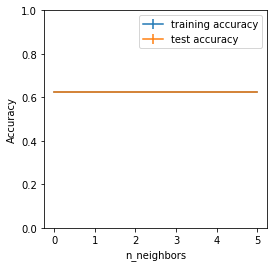

Highest Test Set Achieved = 0.625265
Best Alpha =  1e-12


In [17]:
X = table2.drop('Amount',axis=1)
y = table2['Amount']
yz=5
from sklearn.linear_model import Lasso
neighbors_settings=[1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,
                            1e-3,1e-2,0.1, 0.2,0.4,0.75, 1, 1.5, 3, 5]
lahat_train = pd.DataFrame()
lahat_test = pd.DataFrame()

with tqdm(total=yz*len(neighbors_settings)) as pb:
    for seedN in range(0,yz):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                            test_size=0.25, random_state=seedN)

        training_accuracy = []
        test_accuracy = []

        pb.set_description(f'Iter: {seedN+1}')
        
        
        for n_neighbors in neighbors_settings:   
            clf = Lasso(alpha=n_neighbors,max_iter=1000)  # build the model
            clf.fit(X_train, y_train)

            training_accuracy.append(clf.score(X_train, y_train)) # record training set accuracy
            test_accuracy.append(clf.score(X_test, y_test))   # record generalization accuracy
            
            pb.update(1)
            
        lahat_train[seedN]= training_accuracy
        lahat_test[seedN] = test_accuracy
        
fig = plt.figure(figsize=(4,4))
plt.errorbar(neighbors_settings, lahat_train.mean(axis=1),
             yerr=lahat_train.var(axis=1), label="training accuracy")
plt.errorbar(neighbors_settings, lahat_test.mean(axis=1),
             yerr=lahat_test.var(axis=1), label="test accuracy")

plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.ylim(0,1)
plt.legend()
plt.show()

n_neighbor_best= np.argmax(lahat_test.mean(axis=1))
print("Highest Test Set Achieved = %f" % np.amax(lahat_test.mean(axis=1)))
print("Best Alpha = ",neighbors_settings[n_neighbor_best])
table.loc['Lasso'] = [np.amax(lahat_train.mean(axis=1)),np.amax(lahat_test.mean(axis=1)),neighbors_settings[n_neighbor_best]]


# Decision Tree Regressor Optimization

Iter: 5: 100%|██████████| 245/245 [00:04<00:00, 52.13it/s]


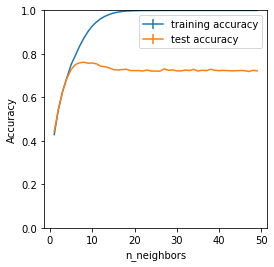

Highest Test Set Achieved = 0.762213
Best Depth = 7


In [18]:
X = table2.drop('Amount',axis=1)
y = table2['Amount']
yz=5

neighbors_settings=range(1,50)
lahat_train = pd.DataFrame()
lahat_test = pd.DataFrame()

with tqdm(total=yz*len(neighbors_settings)) as pb:
    for seedN in range(0,yz):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                            test_size=0.25, random_state=seedN)

        training_accuracy = []
        test_accuracy = []

        pb.set_description(f'Iter: {seedN+1}')
        
        
        for n_neighbors in neighbors_settings:   
            clf = DecisionTreeRegressor(max_depth=n_neighbors)  # build the model
            clf.fit(X_train, y_train)

            training_accuracy.append(clf.score(X_train, y_train)) # record training set accuracy
            test_accuracy.append(clf.score(X_test, y_test))   # record generalization accuracy
            
            pb.update(1)
            
        lahat_train[seedN]= training_accuracy
        lahat_test[seedN] = test_accuracy
        
fig = plt.figure(figsize=(4,4))
plt.errorbar(neighbors_settings, lahat_train.mean(axis=1),
             yerr=lahat_train.var(axis=1), label="training accuracy")
plt.errorbar(neighbors_settings, lahat_test.mean(axis=1),
             yerr=lahat_test.var(axis=1), label="test accuracy")

plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.ylim(0,1)
plt.legend()
plt.show()

n_neighbor_best= np.argmax(lahat_test.mean(axis=1))
print("Highest Test Set Achieved = %f" % np.amax(lahat_test.mean(axis=1)))
print("Best Depth = %d" %n_neighbor_best)
table.loc['DecisionTree'] = [np.amax(lahat_train.mean(axis=1)),np.amax(lahat_test.mean(axis=1)), n_neighbor_best]


# Random Forest Grid Search

In [22]:
X = table2.drop('Amount',axis=1)
y = table2['Amount']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25)

In [23]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred


In [25]:
from sklearn.model_selection import GridSearchCV

param_grids = {'max_depth': [12,14,16,18,20,22,24],
               'n_estimators':[100,200,300,400,500,600],
              'min_samples_leaf': [0.6,0.8,1,2,3,4],
              'max_features': [3,2,1,0.8,0.6,0.4,0.2,0.1],'min_samples_split': [2,4,6] 
}   

model= RandomForestRegressor()

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grids, cv=2, scoring_fit='r2')

print(model.best_score_)
print(model.best_params_)

Fitting 2 folds for each of 8640 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

0.8414007964841045
{'max_depth': 20, 'max_features': 0.4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [27]:
table.loc['RandomForest '] = ['Used Grid Search',model.best_score_, model.best_params_]

# Extra Trees Grid Search

In [35]:
from sklearn.model_selection import GridSearchCV

param_grids = {'max_depth': [20,22,24,26,28],
               'n_estimators':[400,500,600,700,800,900,1000],
              'min_samples_leaf': [0.8,1,2,3],
              'max_features': [5,4,3,'auto','sqrt','log2']
}   

model= ExtraTreesRegressor()

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grids, cv=2, scoring_fit='r2')

print(model.best_score_)
print(model.best_params_)

Fitting 2 folds for each of 840 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:  6.9min finished


0.8439668296488572
{'max_depth': 26, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 700}


In [37]:
table.loc['Extra Tree'] = ['Used Grid Search',model.best_score_, model.best_params_]

# Gradient Boosting Grid Search

In [38]:
from sklearn.model_selection import GridSearchCV

param_grids = {'learning_rate': [ 0.0075,0.005,0.01,0.02,0.05,0.075],
    'max_depth': [4,6,8,10,12],
               'n_estimators':[500,600,700,800,900,1000,1100],
              'min_samples_leaf': [0.8,1,3],
              'max_features': [1,0.8,0.6,0.4,0.2,0.1,'auto','sqrt','log2'],
}   

model= GradientBoostingRegressor()

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grids, cv=2, scoring_fit='r2')

print(model.best_score_)
print(model.best_params_)

Fitting 2 folds for each of 5670 candidates, totalling 11340 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1037 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1482 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2009 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 2616 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 3305 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 4074 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 4925 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 5856 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 6869 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 7962 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 9137 tasks      |

0.8519289516747679
{'learning_rate': 0.05, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 900}


In [39]:
table.loc['Gradient Boosting'] = ['Used Grid Search',model.best_score_, model.best_params_]

# XGB Grid Search

In [42]:
from sklearn.model_selection import GridSearchCV

param_grids = {'learning_rate': [0.005,0.01,0.025,0.05,0.075,0.1,0.2],
    'max_depth': [2,4,6,8,10],
               'n_estimators':[300,400,500,600,700,800]
}   

model= XGBRegressor()

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grids, cv=2, scoring_fit='r2')

print(model.best_score_)
print(model.best_params_)

Fitting 2 folds for each of 210 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  1.3min finished


0.835655662536507
{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 600}


In [43]:
table.loc['XGB'] = ['Used Grid Search',model.best_score_, model.best_params_]

# Lightboost Grid Search

In [44]:
from sklearn.model_selection import GridSearchCV

param_grids = {'learning_rate': [ 0.01,0.02,0.05,0.075,0.1,0.2],
    'max_depth': [2,4,6,8,10,12],
               'n_estimators':[300,400,500,600,700,800],
              'min_samples_leaf': [0.4,0.6,0.8,1,1.2],
              'max_features': [2,1.8,1.6,1.4,1.2,1,0.8,0.6]
}   

model= LGBMRegressor()

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grids, cv=2, scoring_fit='r2')

print(model.best_score_)
print(model.best_params_)

Fitting 2 folds for each of 8640 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

0.8345858191550148
{'learning_rate': 0.05, 'max_depth': 6, 'max_features': 2, 'min_samples_leaf': 0.4, 'n_estimators': 600}


In [45]:
table.loc['Lightboost'] = ['Used Grid Search',model.best_score_, model.best_params_]

# Catboost Grid Search

In [47]:
from sklearn.model_selection import GridSearchCV

param_grids = {'learning_rate': [0.05,0.075,0.1,0.2,0.3],
    'max_depth': [2,4,6,8,10],
               'n_estimators':[900,1000,1100,1200,1300,1400]}   

model= CatBoostRegressor(verbose=False)

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grids, cv=2, scoring_fit='r2')

print(model.best_score_)
print(model.best_params_)

Fitting 2 folds for each of 150 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.8min finished


0.8434155062983847
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1200}


In [48]:
table.loc['Catboost'] = ['Used Grid Search',model.best_score_, model.best_params_]

In [49]:
table

,Train_Accuracy,Test_Accuracy,Optimal Parameter
KNN,0.999941,0.643385,12
LR,0.623799,0.625265,N/A
Ridge,0.623799,0.625265,1e-12
Lasso,0.623799,0.625265,1e-12
DecisionTree,0.999972,0.762213,7
RandomForest,Used Grid Search,0.841401,"{'max_depth': 20, 'max_features': 0.4, 'min_sa..."
Extra Tree,Used Grid Search,0.843967,"{'max_depth': 26, 'max_features': 'log2', 'min..."
Gradient Boosting,Used Grid Search,0.851929,"{'learning_rate': 0.05, 'max_depth': 6, 'max_f..."
XGB,Used Grid Search,0.835656,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est..."
Lightboost,Used Grid Search,0.834586,"{'learning_rate': 0.05, 'max_depth': 6, 'max_f..."


In [50]:
table.to_csv('Tuning_Parameters.csv')